In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import model_from_json
from sklearn.metrics import roc_auc_score

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
fashion_mnist.load_data

<function keras.src.datasets.fashion_mnist.load_data()>

In [4]:
X_train_tensor = X_train.astype('float32')/255.0
X_test_tensor = X_test.astype('float32')/255.0

In [5]:
X_train_tensor[1:].max()

1.0

In [6]:
y_train_labels = to_categorical(y_train)
y_test_labels = to_categorical(y_test)

In [7]:
INPUT_SHAPE = (X_train_tensor.shape[1:]+(1,))
HIDDEN_UNITS = 128
DROPOUT = 0.2
NUM_CLASSES = len(np.unique(y_test))
BATCH_SIZE = 64

In [8]:
INPUT_SHAPE

(28, 28, 1)

In [9]:
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))
model.add(Dense(units=HIDDEN_UNITS))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(units=HIDDEN_UNITS, activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Flatten())
model.add(Dense(units=HIDDEN_UNITS, activation='relu'))
model.add(Dense(units=HIDDEN_UNITS, activation='relu'))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 28, 128)       256       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 128)       512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 128)       0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 28, 28, 128)       16512     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0         
                                                        

In [11]:
np.expand_dims(X_train, -1).shape

(60000, 28, 28, 1)

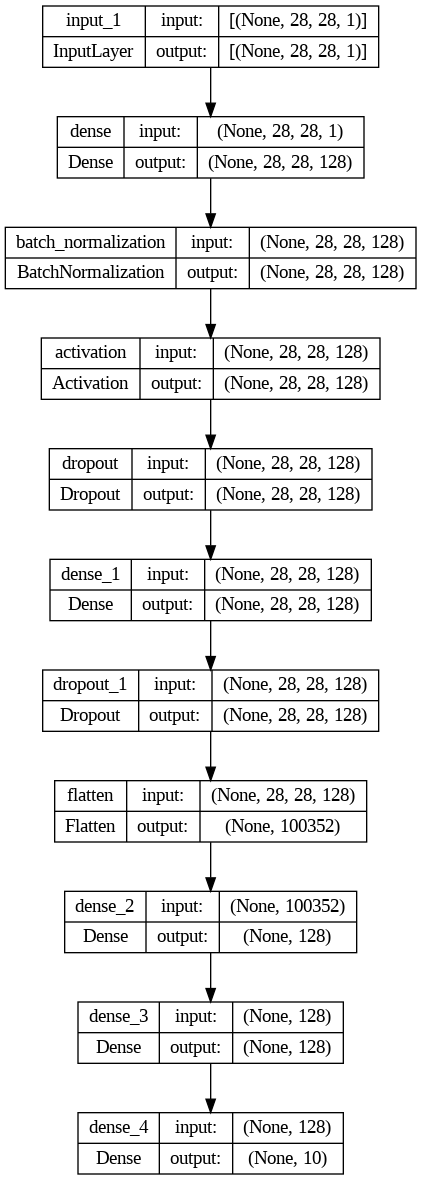

In [12]:
plot_model(model, show_shapes=True)

In [13]:
!mkdir model_output
!ls /content/*

/content/model.png

/content/model_output:

/content/sample_data:
anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [14]:
earlystop = EarlyStopping(monitor='loss', patience=10)

In [15]:
filepath='/content/model_output/' + 'weights-{epoch:02d}-loss-{loss:04f}.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=False,
                             save_freq='epoch')

In [16]:
class my_custom_callback(Callback):
  def __init__(self, features, target):
    self.test_data = (features, target)
    self.auc = []

  def on_epoch_end(self, epoch, logs=None):
    y_pred = self.model.predict(self.test_data[0])
    auc = roc_auc_score(self.test_data[1], y_pred)
    print(' \n auc score for val set :', auc, '\n')
    self.auc.append((epoch, auc))
    return

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [18]:
mycallback=my_custom_callback(X_test_tensor, y_test_labels)

In [19]:
model.fit(X_train_tensor, y_train_labels, epochs=20, batch_size=BATCH_SIZE, verbose=1,
          validation_data=(X_test_tensor, y_test_labels), callbacks=[mycallback, earlystop, checkpoint])

Epoch 1/20
313/313 [==============================] - 2s 4ms/step
 
 auc score for val set : 0.9860876555555557 

938/938 [==============================] - 23s 20ms/step - loss: 0.5723 - acc: 0.8144 - val_loss: 0.4375 - val_acc: 0.8415
Epoch 2/20
313/313 [==============================] - 1s 3ms/step
 
 auc score for val set : 0.9873167777777777 

938/938 [==============================] - 17s 19ms/step - loss: 0.3794 - acc: 0.8610 - val_loss: 0.4391 - val_acc: 0.8479
Epoch 3/20
313/313 [==============================] - 1s 3ms/step
 
 auc score for val set : 0.9885587999999998 

938/938 [==============================] - 17s 18ms/step - loss: 0.3472 - acc: 0.8719 - val_loss: 0.3740 - val_acc: 0.8641
Epoch 4/20
313/313 [==============================] - 1s 3ms/step
 
 auc score for val set : 0.9878548111111112 

938/938 [==============================] - 18s 19ms/step - loss: 0.3132 - acc: 0.8836 - val_loss: 0.3918 - val_acc: 0.8586
Epoch 5/20
313/313 [==============================] 

In [20]:
model_json = model.to_json()

with open('model.json', 'w') as json_file:
  json_file.write(model_json)

In [21]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [22]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 28, 128)       256       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 128)       512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 128)       0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 28, 28, 128)       16512     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0         
                                                        

In [24]:
!ls /content/model_output/*

/content/model_output/weights-01-loss-0.572264.h5
/content/model_output/weights-02-loss-0.379355.h5
/content/model_output/weights-03-loss-0.347206.h5
/content/model_output/weights-04-loss-0.313185.h5
/content/model_output/weights-05-loss-0.292206.h5
/content/model_output/weights-06-loss-0.269696.h5
/content/model_output/weights-07-loss-0.245499.h5
/content/model_output/weights-08-loss-0.228248.h5
/content/model_output/weights-09-loss-0.212247.h5
/content/model_output/weights-10-loss-0.196016.h5
/content/model_output/weights-11-loss-0.181452.h5
/content/model_output/weights-12-loss-0.166215.h5
/content/model_output/weights-13-loss-0.154823.h5
/content/model_output/weights-14-loss-0.143953.h5
/content/model_output/weights-15-loss-0.133303.h5
/content/model_output/weights-16-loss-0.125363.h5
/content/model_output/weights-17-loss-0.116794.h5
/content/model_output/weights-18-loss-0.109537.h5
/content/model_output/weights-19-loss-0.101377.h5
/content/model_output/weights-20-loss-0.098044.h5


In [25]:
loaded_model.load_weights('/content/model_output/weights-20-loss-0.098044.h5')

In [26]:
preds = loaded_model.predict(X_test_tensor)

313/313 [==============================] - 1s 3ms/step


In [27]:
pd.crosstab(np.argmax(y_test_labels, 1), np.argmax(preds, 1))

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,846,2,14,20,3,1,110,0,4,0
1,6,963,2,14,5,0,10,0,0,0
2,19,1,747,10,129,0,92,0,2,0
3,30,5,12,853,58,0,37,1,4,0
4,1,0,71,14,855,0,55,0,4,0
5,0,0,0,1,0,946,0,42,2,9
6,135,3,63,23,97,0,671,0,8,0
7,0,0,0,0,0,11,0,985,0,4
8,2,1,2,2,5,5,5,7,971,0


| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |